In [114]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from random import sample
%matplotlib inline

DIR = 'data'

In [115]:
# Reading names
words = list(set(open(f'{DIR}/names.txt').read().splitlines()))
words[:5]

['ieretha', 'bruni', 'bran', 'rachoisa', 'marry']

In [116]:
symbols = sorted(list(set(''.join(words))))
num_of_symbols = 1 + len(symbols)   # adding '.' to the vocab
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [117]:
stoi = {ch: i + 1 for i, ch in enumerate(symbols)}
stoi['.'] = 0

itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 0: '.'}


### Building dataset
_block_size_: context length (how many previous characters are considered in the prediction) 

_X_: neural net inputs 

_Y_: neural net input labels

In [118]:
block_size = 3
X, Y = [], []

In [119]:
def train_test_split(X: torch.tensor, Y: torch.tensor, p: float):
    train_size = int(p * X.shape[0])

    idxs = set([i for i in range(X.shape[0])])
    train_idxs = set(sample(idxs, k=train_size))
    test_idxs = idxs - train_idxs

    train_idxs, test_idxs = list(train_idxs), list(test_idxs)
    return X[train_idxs], Y[train_idxs], X[test_idxs], Y[test_idxs]

In [120]:
for name in words:
    context = [0] * block_size
    for ch in name + '.':
        idx = stoi[ch]
        X.append(context)
        Y.append(idx)

        # context update
        context = context[1:] + [idx] 

X, Y = torch.tensor(X), torch.tensor(Y)

In [121]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.8)

/tmp/ipykernel_835/1926032739.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_idxs = set(sample(idxs, k=train_size))


### Layer Classes 

In [122]:
def add_to_class(Class): 
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [123]:
class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias: bool=True) -> None:
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self) -> list:
        return [self.weights] + ([] if self.bias is None else [self.bias])

In [124]:
class BatchNorm1d:
    def __init__(self, dim: int, eps: float=1e-5, momentum: float=.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def parameters(self) -> list:
        return [self.gamma, self.beta]

In [125]:
@add_to_class(BatchNorm1d)
def __call__(self, x: torch.tensor) -> torch.tensor:
    if self.training:
        x_mean = x.mean(0, keepdims=True)
        x_var = x.var(0, keepdims=True)
    else:
        x_mean = self.running_mean
        x_var = self.running_var
    
    x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
    self.out = self.gamma * x_hat + self.beta

    if self.training:
        with torch.no_grad():
            self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1-self.momentum) * self.running_var + self.momentum * x_var
        
    return self.out

In [126]:
class Tanh:
    def __call__(self, x: torch.tensor) -> None:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> list:
        return []

### Parameters and Model Configuration

In [127]:
# Hyperparameters
emb_dimensions = 10
num_of_neurons = 100 

minibatch_size = 32
num_of_epochs = 200000

In [128]:
## NN parameters
hl_input_length = block_size * emb_dimensions
C = torch.randn((num_of_symbols, emb_dimensions))
layers = [
    Linear(hl_input_length, num_of_neurons, bias=False), BatchNorm1d(num_of_neurons), Tanh(),
    Linear(num_of_neurons, num_of_neurons, bias=False), BatchNorm1d(num_of_neurons), Tanh(),
    Linear(num_of_neurons, num_of_neurons, bias=False), BatchNorm1d(num_of_neurons), Tanh(),
    Linear(num_of_neurons, num_of_neurons, bias=False), BatchNorm1d(num_of_neurons), Tanh(),
    Linear(num_of_neurons, num_of_neurons, bias=False), BatchNorm1d(num_of_neurons), Tanh(),
    Linear(num_of_neurons, num_of_symbols, bias=False), BatchNorm1d(num_of_symbols)
]

In [129]:
with torch.no_grad():
    # making last layer less confident
    layers[-1].gamma  *= .1

    # applying gain to all other linear layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 1.0

In [130]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

### Model Training

In [131]:
losses = []
epochs = []

In [132]:
for i in range(num_of_epochs + 1):
    idx = torch.randint(0, X_train.shape[0], (minibatch_size,))
    X_batch, Y_batch = X_train[idx], Y_train[idx]

    """ Forward pass """
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)                
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)                        

    """ Backward pass """
    for p in parameters:
        p.grad = None
    loss.backward()

    """ Update """
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    """ Tracking Stats """
    if not i % 10000:
        print(f"epoch {i}/{num_of_epochs}: {loss.item():.4f}")
    losses.append(loss.item())
    epochs.append(i)

epoch 0/200000: 3.1727
epoch 10000/200000: 1.6132
epoch 20000/200000: 1.8664
epoch 30000/200000: 1.3132
epoch 40000/200000: 1.6636
epoch 50000/200000: 1.6134
epoch 60000/200000: 1.4689
epoch 70000/200000: 1.4917
epoch 80000/200000: 1.7354
epoch 90000/200000: 1.2872
epoch 100000/200000: 1.5251
epoch 110000/200000: 1.3061
epoch 120000/200000: 1.4025
epoch 130000/200000: 1.1994
epoch 140000/200000: 1.7898
epoch 150000/200000: 1.8445
epoch 160000/200000: 1.4454
epoch 170000/200000: 1.8238
epoch 180000/200000: 1.6577
epoch 190000/200000: 1.5060
epoch 200000/200000: 1.7648


### Loss curve

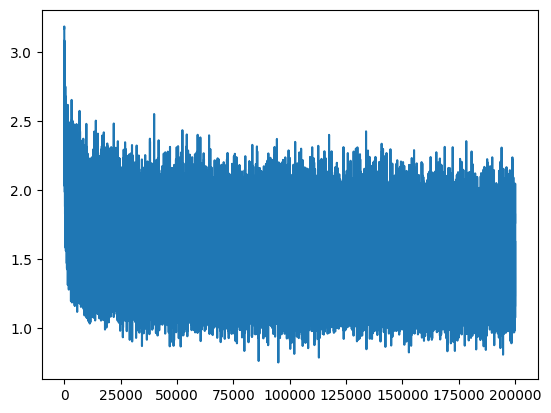

In [136]:
plt.plot(epochs, losses)

In [137]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'test': (X_test, Y_test),
    }[split]
    emb = C[x] 
    x = emb.view(emb.shape[0], -1) 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in layers:
    layer.training = False
split_loss('train')
split_loss('test')

train 1.4439725875854492
test 1.4574494361877441


### Sampling from the model

In [138]:
samples = []
for _ in range(10):
    idx, out = 0, ""
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] 
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [idx]
        if idx == 0:
            break

        out += itos[idx]
    samples.append(out)

print(samples)

['elendisa', 'eiryl', 'cath', 'ise', 'wippia', 'bilblia', 'darbia', 'mippy', 'anvangra', 'kes']
